## Plotting with value overlay
In this example we will try to read the current forecast from the NOAA Global Forecast Model (GFS).  Again, we'll seek to pull the recent data, whatever recent happens to mean.  In this notebook we draw the mean sea level pressure and highlight/mark the highs and lows.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from mpl_toolkits.basemap import Basemap, addcyclic
from scipy.ndimage.filters import minimum_filter, maximum_filter
from netCDF4 import Dataset

In [2]:
def extrema(mat,mode='wrap',window=10):
    """find the indices of local extrema (min and max)
    in the input array."""
    mn = minimum_filter(mat, size=window, mode=mode)
    mx = maximum_filter(mat, size=window, mode=mode)
    # (mat == mx) true if pixel is equal to the local max
    # (mat == mn) true if pixel is equal to the local in
    # Return the indices of the maxima, minima
    return np.nonzero(mat == mn), np.nonzero(mat == mx)

In [4]:
# Find out what today is.  The syntax below should give a 
#   string like "20200828" for August 28, 2020.  We also
#   add "00" to the end since that's how the GFS forecast
#   filenames are.
forecast_date = datetime.now().strftime('%Y%m%d')+'00'

# Open OpenDAP dataset.  The syntax of including %s in the
#   the string is a way of including one string in another
#   (before we used something like string1 + "and" + string2).
#   Here we want to insert the first part of "forecast_date",
#   i.e., the 20200828 part, then the last part ("00").
#   We want the url to look like this:
#   https://nomads.ncep.noaa.gov:9090/dods/gfs_1p00/gfs20200415/gfs_1p00_00z

#url = 'https://nomads.ncep.noaa.gov:9090/dods/gfs_1p00/gfs%s/gfs_1p00_00z'%forecast_date[0:8]
url = 'https://nomads.ncep.noaa.gov:9090/dods/gfs_1p00/gfs20201208/gfs_1p00_00z'
data = Dataset(url)

OSError: [Errno -77] NetCDF: Access failure: b'https://nomads.ncep.noaa.gov:9090/dods/gfs_1p00/gfs20201208/gfs_1p00_00z'

In [4]:
# read lats,lons.
lats = data.variables['lat'][:]
lons = data.variables['lon'][:]
nlats = len(lats)
nlons = len(lons)
# read mean sea level pressure (prmslmsl) and convert to milibars
sealevel_press = 0.01 * data.variables['prmslmsl'][0]

In [5]:
# Find the min/max in pressure, i.e., the highs and lows. The
#   window arguement controls the number, but note the larger
#   this is means fewer highs and lows found
local_min, local_max = extrema(sealevel_press, mode='wrap', window=50)

In [6]:
# Now make the map create Basemap instance.
m = Basemap(llcrnrlon=0,llcrnrlat=-80,urcrnrlon=360,urcrnrlat=80,projection='mill')

# Add wrap-around point in longitude.
sealevel_press, lonsw = addcyclic(sealevel_press, lons)

# Set contour levels
clevs = np.arange(900,1100.,5.)

# find x,y of map projection grid.
lonsw, lats = np.meshgrid(lonsw, lats)
x, y = m(lonsw, lats)

/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


Text(0.5, 1.0, 'Mean Sea-Level Pressure 2020041500')

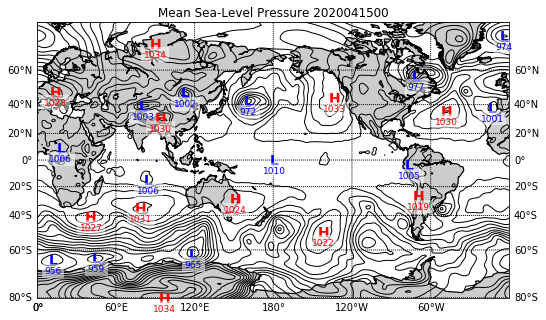

In [8]:
# Now make our plot
fig = plt.figure(figsize=(8,4.5))
ax = fig.add_axes([0.05,0.05,0.9,0.85])
cs = m.contour(x,y,sealevel_press,clevs,colors='k',linewidths=1.)

# Draw coastlines, shade continents, and draw lat/lon lines
m.drawcoastlines(linewidth=1.25)
m.fillcontinents(color='0.8')
m.drawparallels(np.arange(-80,81,20),labels=[1,1,0,0])
m.drawmeridians(np.arange(0,360,60),labels=[0,0,0,1])

xlows = x[local_min]; xhighs = x[local_max]
ylows = y[local_min]; yhighs = y[local_max]
lowvals = sealevel_press[local_min]
highvals = sealevel_press[local_max]

# Plot lows as blue L's, with min pressure value underneath.
xyplotted = []
# don't plot if there is already a L or H within dmin meters.
yoffset = 0.022*(m.ymax-m.ymin)
dmin = yoffset
for x,y,p in zip(xlows, ylows, lowvals):
    if x < m.xmax and x > m.xmin and y < m.ymax and y > m.ymin:
        dist = [np.sqrt((x-x0)**2+(y-y0)**2) for x0,y0 in xyplotted]
        if not dist or min(dist) > dmin:
            plt.text(x,y,'L',fontsize=14,fontweight='bold',
                    ha='center',va='center',color='b')
            plt.text(x,y-yoffset,repr(int(p)),fontsize=9,
                    ha='center',va='top',color='b',
                    bbox = dict(boxstyle="square",ec='None',fc=(1,1,1,0.5)))
            xyplotted.append((x,y))
# plot highs as red H's, with max pressure value underneath.
xyplotted = []
for x,y,p in zip(xhighs, yhighs, highvals):
    if x < m.xmax and x > m.xmin and y < m.ymax and y > m.ymin:
        dist = [np.sqrt((x-x0)**2+(y-y0)**2) for x0,y0 in xyplotted]
        if not dist or min(dist) > dmin:
            plt.text(x,y,'H',fontsize=14,fontweight='bold',
                    ha='center',va='center',color='r')
            plt.text(x,y-yoffset,repr(int(p)),fontsize=9,
                    ha='center',va='top',color='r',
                    bbox = dict(boxstyle="square",ec='None',fc=(1,1,1,0.5)))
            xyplotted.append((x,y))
plt.title('Mean Sea-Level Pressure %s' % forecast_date)